# **Pet Classification**
## Image Processing and Computer Vision - Assignment Module 2

- Katia Gramaccini - katia.gramaccini@studio.unibo.it
- Giada Triulzi - giada.triulzi@studio.unibo.it

### **Description of the task**

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts.

- In Part 1, we implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`.

- In Part 2, we fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. We fine-tune the ResNet-18 with the same training hyperparameters we used for our best model in part 1. Then, we tweak the training hyperparameters in order to increase the accuracy on the test split.

-------------------------------------------------------

## **Importing dependencies**

### **Importing the relevant repository**

In [ ]:
# # Uncomment to execute when using Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

fatal: destination path 'ipcv-assignment-2' already exists and is not an empty directory.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Optional

import os, json
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from collections import Counter


from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.classification.accuracy import Accuracy
from torchsummary import summary
from torchvision import transforms as T
from torchmetrics import ConfusionMatrix
from torchvision.models import resnet18, ResNet18_Weights

import io
from contextlib import redirect_stdout
import re

### **GPU support**

In [3]:
gpu_avail = torch.cuda.is_available()
print(f"Is cuda available? {gpu_avail}")
device = torch.device("cuda") if gpu_avail else torch.device("cpu")
print(f"Device: {device}")

torch.cuda.empty_cache()

Is cuda available? True
Device: cuda


### **Setting seeds**

In [4]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

## **Dataset preparation**

In [5]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, label
    
    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name), 
                labels.append(int(label) - 1)

        return names, labels

We first map numerical labels to breed names by creating a dictionary.

In [6]:
labels_path = Path("ipcv-assignment-2")/"dataset"/"annotations"/"val.txt"
breed_dict = {}
counter = 0
with open(labels_path) as f:
    for line in f:
        idx = line.rfind("_")
        breed_name = line[:idx]
        breed_name = breed_name.replace("_", " ").lower()
        if breed_name not in breed_dict.keys():
            breed_dict[breed_name] = counter
            counter += 1

pd.DataFrame.from_dict(breed_dict, orient='index', columns=["index"])


index
abyssinian                      0
american bulldog                1
american pit bull terrier       2
basset hound                    3
beagle                          4
bengal                          5
birman                          6
bombay                          7
boxer                           8
british shorthair               9
chihuahua                      10
egyptian mau                   11
english cocker spaniel         12
english setter                 13
german shorthaired             14
great pyrenees                 15
havanese                       16
japanese chin                  17
keeshond                       18
leonberger                     19
maine coon                     20
miniature pinscher             21
newfoundland                   22
persian                        23
pomeranian                     24
pug                            25
ragdoll                        26
russian blue                   27
saint bernard                  28
samoyed                        29
scottish terrier               30
shiba inu                      31
siamese                        32
sphynx                         33
staffordshire bull terrier     34
wheaten terrier                35
yorkshire terrier              36

### **Hyperparameters configuration**

We then set the hyperparameters configuration that will be used by our best model.

In [7]:
cfg = {
    # Pre-processing parameters
    "resize_size": 256,
    "crop_size": 224,

    # Training parameters
    "batch_size": 16,
    "num_epochs": 50, 

    # Optimizer parameters
    "lr": 5e-4, #learning rate
    "wd": 2e-4, #weight decay

    #Early stopping params
    "patience":10,

    #Label smoothing params
    "smoothing":0.1,

    #Lr scheduler on/off
    "scheduler": True
}

### **Dataset augmentation**

We compute images' mean and standard deviation.

In [139]:
# Define transform to convert images to tensors
transform = T.Compose([
    T.Resize(cfg['resize_size']),  # mimic preprocessing scale
    T.CenterCrop(cfg["crop_size"]),           # deterministic crop of same size
    T.ToTensor()
])

# Load your dataset
train_ds_pre = OxfordPetDataset(split="train", transform=transform)
train_dl_pre = DataLoader(train_ds_pre, batch_size=cfg["batch_size"], shuffle=True, num_workers=0)

mean = 0.
std = 0.
nb_samples = 0

for data, _ in train_dl_pre:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)  # flatten H*W per channel
    mean += data.mean(2).sum(0)                         # sum over batch
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4908, 0.4525, 0.3973])
Std: tensor([0.2277, 0.2255, 0.2264])


Our training dataset' statistics are close to the mean and standard deviation computed on the ImageNet dataset. This means that we can normalize by using ImageNet statistics: we do this because the ResNet model that will be used in Part 2 was trained on ImageNet. Since we want to use the same DataLoaders, if we use different statistics during fine-tuning the ResNet model will have a worse performance, since it was pre-trained differently.

We also want to add randomness to the training set, so we add `RandomResizedCrop`, `RandomHorizontalFlip` and `RandomRotation` to the training transformation pipeline.

In [ ]:
mean_image_net = [0.485, 0.456, 0.406]
std_image_net = [0.229, 0.224, 0.225]

data_transforms = {
    "train_base": T.Compose([T.Resize(cfg["resize_size"]),
                        T.CenterCrop(cfg["crop_size"]),
                        T.ToTensor(),
                        T.Normalize(mean_image_net, std_image_net)]),

    "train_aug": T.Compose([T.RandomResizedCrop(cfg["crop_size"], scale=(0.6, 1)),
                        T.RandomHorizontalFlip(),
                        T.RandomRotation(10),
                        T.ToTensor(),
                        T.Normalize(mean_image_net, std_image_net)]),

    "val": T.Compose([T.Resize(cfg["resize_size"]),
                      T.CenterCrop(cfg["crop_size"]),
                      T.ToTensor(),
                      T.Normalize(mean_image_net, std_image_net)])
}

### **Dataloaders definition**

In [ ]:
train_ds = OxfordPetDataset(split="train", transform=data_transforms["train_aug"])
train_dl = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True, num_workers=0, pin_memory=True)

val_ds = OxfordPetDataset(split="val", transform=data_transforms["val"])
val_dl = DataLoader(val_ds, batch_size=cfg["batch_size"], shuffle=False, num_workers=0)

test_ds = OxfordPetDataset(split="test", transform=data_transforms["val"])
test_dl = DataLoader(test_ds, batch_size=cfg["batch_size"], shuffle=False, num_workers=0)

## **Dataset inspection**

We want to visualize some images (a batch of 8 images), but since we have normalized the data to make training more stable, tensors values are not valid RGB values anymore. To have a correct visualization, then, we have to unnormalize the images before printing them.

In [11]:
# Helper to unnormalize a batch for visualization
def unnormalize_batch(images, mean, std):
    device = images.device
    mean = torch.tensor(mean, device=device).view(1, 3, 1, 1)
    std = torch.tensor(std, device=device).view(1, 3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)  # keep in [0,1] for matplotlib
    return images

# Show one batch from a DataLoader
def show_batch(dl, mean=mean_image_net, std=std_image_net, max_images=8):
    images, labels = next(iter(dl))  # get one batch
    images = unnormalize_batch(images, mean, std)
    
    images = images.permute(0, 2, 3, 1).numpy()  # [B,H,W,C] for matplotlib
    batch_size = images.shape[0]
    
    fig, axes = plt.subplots(1, min(batch_size, max_images), figsize=(18, 5))
    if min(batch_size, max_images) == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        for name, idx in breed_dict.items():
            if idx == labels[i].item():
                ax.set_title(f"Label: {name}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


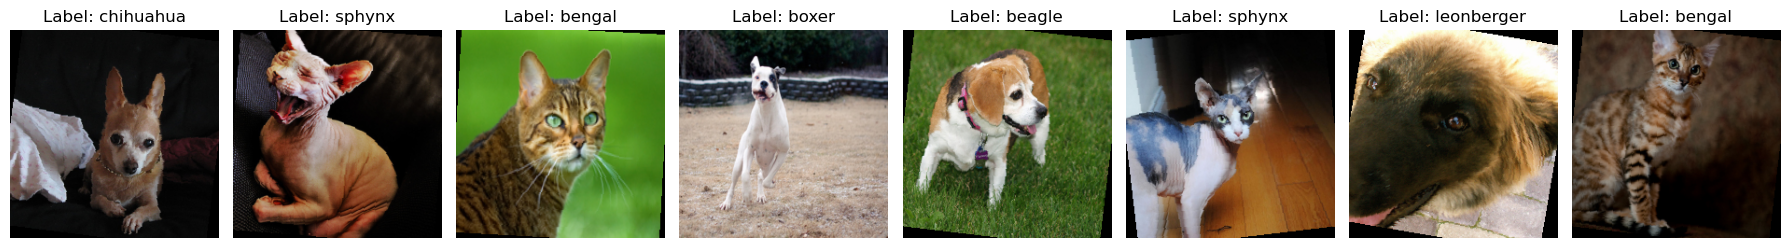

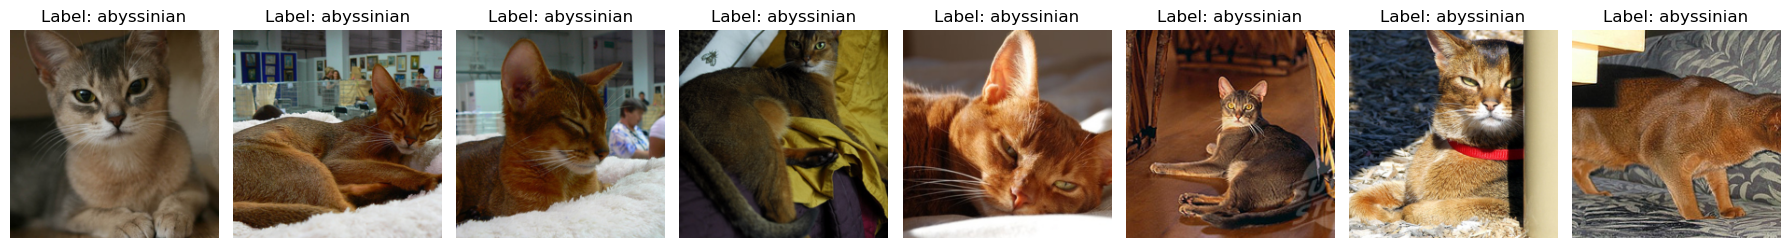

In [12]:
show_batch(train_dl)       # shows one batch from training loader
show_batch(val_dl)         # shows one batch from validation loader


### **Training and validation data distribution**

Then, we take a look at the data distribution for both the training and the validation sets to see whether there are important class imbalances that could affect training.

In [13]:
all_labels_train = []

for _, labels in train_dl:
    #append each item from the iterable (single batch)
    all_labels_train.extend(labels.tolist())

class_counts_train = Counter(all_labels_train)

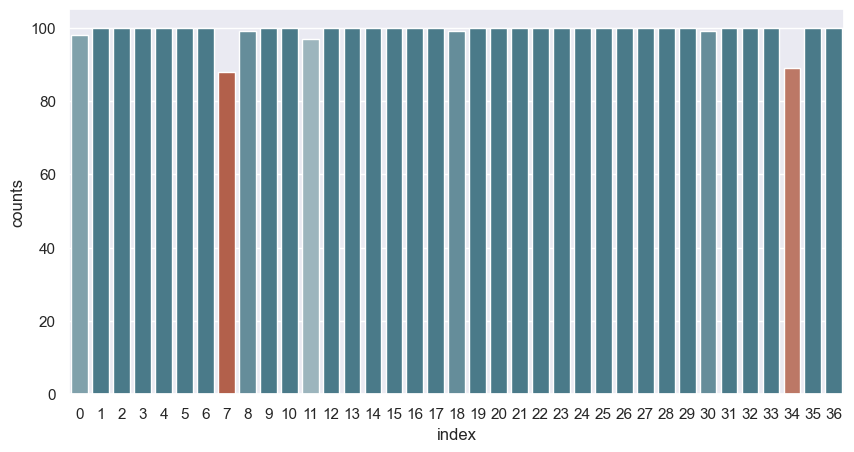

In [14]:
train_df = pd.DataFrame.from_dict(class_counts_train, orient='index', columns=["counts"]).reset_index()
palette = sns.diverging_palette(20, 220, as_cmap=True)

sns.set_theme()
plt.figure(figsize=(10,5))
sns.barplot(data=train_df, x='index', y='counts', hue='counts', legend=False, palette=palette)
plt.show()

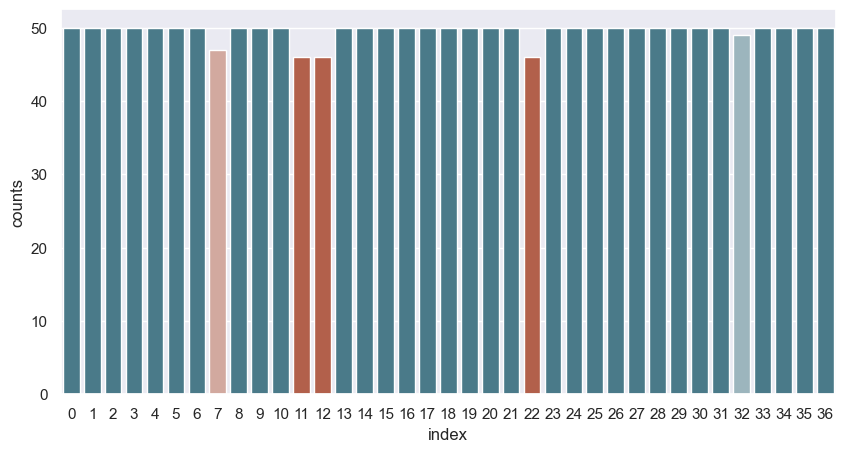

In [15]:
all_labels_val = []

for _, labels in val_dl:
    #append each item from the iterable (single batch)
    all_labels_val.extend(labels.tolist())

class_counts_val = Counter(all_labels_val)

val_df = pd.DataFrame.from_dict(class_counts_val, orient='index', columns=["counts"]).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=val_df, x='index', y='counts', hue='counts', legend=False, palette=palette)
plt.show()


From the bar plots we can conclude that both the training and the validation sets have quite balanced distributions, with classes having around 100 and 50 elements each respectively.

## **PART 1: CNN design**

### **Best model (baseline)**

The network begins with a stem layer made by a 7×7 convolution with stride 2 followed by max pooling to quickly downsample the input. It then passes through three convolutional blocks, each composed of two consecutive 3×3 convolutions followed by Batch Normalization and ReLU activation. After each block, a max pooling layer further reduces spatial size, allowing the network to capture increasingly abstract features as the channel depth expands from 32 up to 128. Once the final feature maps are extracted, an adaptive average pooling layer compresses them to a fixed 1×1 representation per channel, which is flattened and passed to a fully connected layer that outputs class logits.

`BaseCNN` defines the core structure of the CNNs and the classifier head that will be reused by the other models. `ConvBlock` defines the feature extraction module made of two convolution layers (with a BN layer and a ReLU activation). `BaselineCNN` is the complete architecture of our best model, defined by subclassing `BaseCNN`. In all modules are flags that will be used later to do the ablation study.

In [ ]:
class BaseCNN(nn.Module): #defines the core structure and the classifier head (forward pass will be defined in each subclass)
    def __init__(self, n_classes=37, bn = True, stem=True, deep=True):
        super().__init__()
        self.bn = bn # for Batch Normalization usage
        self.stem = stem # for presence of stem layer
        self.deep = deep # for deeper architecture

        classifier_list = [nn.AdaptiveAvgPool2d((1,1)), nn.Flatten()]
        if self.deep: 
            out_channels=128
        else: 
            out_channels=96
        classifier_list.append(nn.Linear(out_channels, n_classes))
        
        self.classifier = nn.Sequential(*classifier_list)

    def conv_layer(self, inp, out, k=3, s=1, p=1):
        # function layers: conv2d, BN, ReLU
        layers = [nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=k, padding=p, stride=s)]
        if self.bn: layers.append(nn.BatchNorm2d(out))
        layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

In [ ]:
class ConvBlock(nn.Module): #feature extraction module
    def __init__(self, in_channels, out_channels, s=1, bn=True):
        super().__init__()
        self.bn = bn # for Batch Normalization usage
        self.conv1 = self.conv_layer_block(in_channels, out_channels, k=3, s=s, p=1)
        self.conv2 = self.conv_layer_block(out_channels, out_channels, k=3, s=1, p=1)
        self.relu = nn.ReLU(inplace=True)

    def conv_layer_block(self, inp, out, k=3, s=1, p=1, relu=True):
        # function layers: conv2d, BN, ReLU
        layers = [nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=k, padding=p, stride=s)]
        if self.bn: layers.append(nn.BatchNorm2d(out))
        if relu: layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def forward(self, x): #define the forward pass
        x_out = self.conv1(x)
        x_out = self.conv2(x_out)
        return x_out 

In [ ]:
class BaselineCNN(BaseCNN): #complete main architecture
    def __init__(self, bn = True, stem=True):
        super().__init__(bn=bn, stem=stem)
        
        self.features = nn.Sequential(
            self.conv_layer(3, 32, k=7, s=2, p=3) if self.stem is True else self.conv_layer(3, 32, k=3, s=1, p=1), #stem layers
            nn.MaxPool2d(2),
            ConvBlock(32, 64, s=1, bn=self.bn),
            nn.MaxPool2d(2),
            ConvBlock(64, 96, s=1, bn=self.bn),
            nn.MaxPool2d(2),
            ConvBlock(96, 128, s=1, bn=self.bn),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x): #forward pass
        x = self.features(x)
        x = self.classifier(x)

        return x

#### **Trainer**

We then define a custom training loop. We will use the `AdamW` optimizer and the `OneCycleLR` scheduler.

In [21]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [ ]:
class Trainer:
    def __init__(
        self,
        model: nn.Module,
        train_loader,
        val_loader,
        cfg: dict,
        device = device,
        num_classes = 37,
    ) -> None:
        torch.cuda.empty_cache()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = cfg["num_epochs"]

        self.model = model.to(device)
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=cfg["lr"],
            weight_decay=cfg["wd"] # to disable: should be 0
        )
        num_steps = self.num_epochs * len(train_loader)
        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=cfg["lr"],
            total_steps=num_steps
        ) if cfg["scheduler"] else None

        self.step = 0
        self.best_acc = 0.0
        self.best_model = None
        self.patience = cfg["patience"]
        self.no_improve = 0 #counter for early stopping
        self.smoothing = cfg["smoothing"]

        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True, parents=True)
        self.model_name = cfg["name"]
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes).to(self.device)

    def train(self, print_res=True, plot_res=True) -> dict:

        #to save for plotting
        train_loss_hist = []
        val_loss_hist = []
        train_acc_hist = []
        val_acc_hist = []

        start.record()

        # loop over the number of epochs, tqdm for progress bar
        for epoch in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train() #model in training mode
            self.accuracy.reset()
            total_loss, total_samples = 0.0, 0 #counters initialization
            
            #loop over batches
            for imgs, labels in self.train_loader:
                #move data to correct device
                imgs, labels = imgs.to(self.device), labels.to(self.device)

                #forward pass
                pred = self.model(imgs) 
                loss = F.cross_entropy(pred, labels, label_smoothing=self.smoothing) #compute cross entropy loss
                #backward pass
                self.optimizer.zero_grad() #reset gradients
                loss.backward() #backpropagate loss
                self.optimizer.step() #update weights with optimizer
                if self.scheduler is not None:
                    self.scheduler.step() #update LR with scheduler


                # keep track of total loss per epoch average
                total_loss += loss.item() * imgs.size(0)
                total_samples += imgs.size(0)

                # update accuracy
                self.accuracy.update(pred, labels)

                # update step counter (used by LR scheduler)
                self.step += 1

            # compute average loss over training samples in the epoch
            train_loss = total_loss / total_samples
            train_acc = self.accuracy.compute().item()
            if print_res:
                print(f"Epoch {epoch+1}: Train loss = {train_loss:.4f}")
                print(f"[train] loss = {train_loss:.4f}, acc = {train_acc:.4f}")

            # compute metrics on validation sets
            val_metrics = self.eval("val", print_res=print_res)
            # save them in lists
            train_loss_hist.append(train_loss)
            train_acc_hist.append(train_acc)
            val_loss_hist.append(val_metrics["loss"])
            val_acc_hist.append(val_metrics["acc"])

            if self.no_improve >= self.patience:
                print(f"Early stopping at epoch {epoch+1}.")
                break
        
        end.record()
        torch.cuda.synchronize()  # wait for everything to finish running on the GPU

        elapsed = f"{0.001 * start.elapsed_time(end):6.5f}" #from ms to seconds


        if plot_res:
            plt.figure(figsize=(14, 7))
            plt.suptitle(f"{self.model._get_name()} - Training vs Validation")
            plt.subplot(1, 2, 1)
            sns.lineplot(train_loss_hist, label="Train loss")
            sns.lineplot(val_loss_hist, label="Val loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Loss per epoch")
            plt.legend()

            plt.subplot(1, 2, 2)
            sns.lineplot(train_acc_hist, label="Train acc")
            sns.lineplot(val_acc_hist, label="Val acc")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.title("Accuracy per epoch")
            plt.legend()
            plt.tight_layout()
            plt.show()

        return {'train loss':train_loss_hist, 'val loss':val_loss_hist, \
                'train acc':train_acc_hist, 'val acc':val_acc_hist, 'train time':elapsed}
            

    @torch.no_grad() #disable gradient computation
    def eval(self, split: str, print_res = True) -> dict:
        self.model.eval() #model in evaluation mode (no Dropout, fixes BN)
        # choose corresponding dataset (train/val)
        loader = self.val_loader
        # track classification accuracy
        acc = Accuracy(task="multiclass", num_classes=self.num_classes).to(self.device)

        # forward pass on all batches
        total_loss, total_samples = 0.0, 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)

            pred = self.model(imgs)
            #smoothing = self.smoothing if split == "train" else 0.0
            loss = F.cross_entropy(pred, labels)
            # track total loss
            total_loss += loss.item() * imgs.size(0)
            total_samples += imgs.size(0)
            # track accuracy
            acc.update(pred, labels)
        
        # compute average loss and accuracy for the split
        loss = total_loss / total_samples
        accuracy = acc.compute().item()
        if print_res:
            print(f"[{split}] loss = {loss:.4f}, acc = {accuracy:.4f}")

        # Save best model based on validation accuracy
        if accuracy > self.best_acc:
            self.no_improve = 0
            self.best_acc = accuracy
            self.best_model = copy.deepcopy(self.model) #keep a deep copy in memory
            # get model name
            file_name = f"{self.model_name}_best_model.pt"
            # save a checkpoint
            torch.save(
                self.best_model.state_dict(),
                self.ckpt_path / file_name
            )
            if print_res:
                print(f"✅ Saved new {self.model_name} best model with acc = {accuracy:.4f}")
        else:
            self.no_improve += 1

        return {"loss":loss, "acc":accuracy}


#### **Training results**

In [23]:
model = BaselineCNN().to(device)

In [24]:
summary(
    model,
    input_size=(3, cfg["crop_size"], cfg["crop_size"]),
    device=str(device)
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]           4,736
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          18,496
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
        ConvBlock-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,392
      BatchNorm2d-14           [-1, 96,

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Train loss = 3.6146
[train] loss = 3.6146, acc = 0.0442
[val] loss = 3.5277, acc = 0.0665
✅ Saved new baseline best model with acc = 0.0665
Epoch 2: Train loss = 3.4708
[train] loss = 3.4708, acc = 0.0908
[val] loss = 3.4302, acc = 0.0872
✅ Saved new baseline best model with acc = 0.0872
Epoch 3: Train loss = 3.3892
[train] loss = 3.3892, acc = 0.1082
[val] loss = 3.3552, acc = 0.0927
✅ Saved new baseline best model with acc = 0.0927
Epoch 4: Train loss = 3.3297
[train] loss = 3.3297, acc = 0.1311
[val] loss = 3.2843, acc = 0.1069
✅ Saved new baseline best model with acc = 0.1069
Epoch 5: Train loss = 3.2574
[train] loss = 3.2574, acc = 0.1502
[val] loss = 3.2329, acc = 0.1238
✅ Saved new baseline best model with acc = 0.1238
Epoch 6: Train loss = 3.1903
[train] loss = 3.1903, acc = 0.1654
[val] loss = 3.1975, acc = 0.1118
Epoch 7: Train loss = 3.1053
[train] loss = 3.1053, acc = 0.2001
[val] loss = 3.2839, acc = 0.0916
Epoch 8: Train loss = 3.0290
[train] loss = 3.0290, acc =

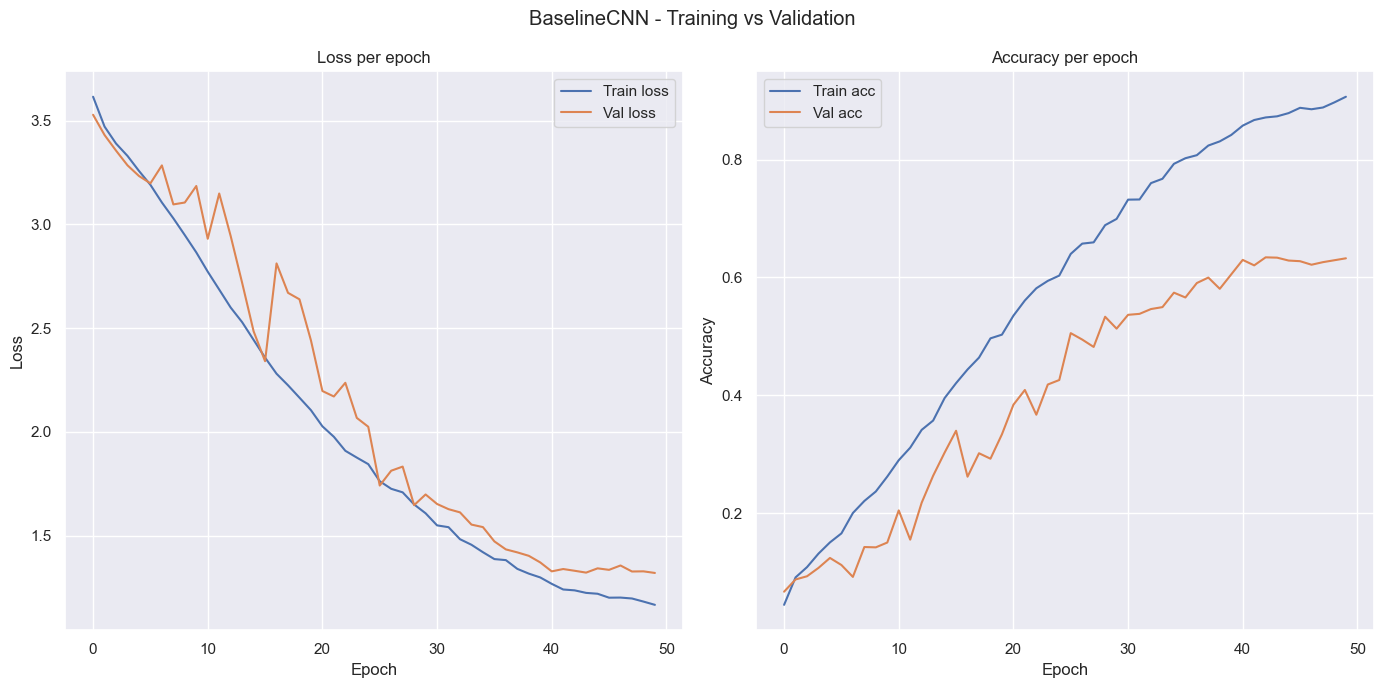

In [25]:
cfg["name"] = "baseline"
trainer = Trainer(
    model,
    train_dl,
    val_dl,
    cfg=cfg
)
stats = trainer.train()

The training logs show that the CNN trains stably and converges well, reaching solid generalization performance over 50 epochs. Initially, both training and validation accuracy were very low (around 4–6%), as expected for random initialization on a 37-class task. However, the model quickly learned useful representations: within the first 10 epochs, validation accuracy doubled several times, reaching about 30% by epoch 15. After epoch 20, training accuracy continued to climb rapidly (from 50% to over 90%), while validation accuracy plateaued between 60–63%. The best performance occurred around epoch 43, with a validation accuracy of roughly 63.4% and validation loss near 1.32. This plateau, along with the growing gap between training and validation accuracy, suggests mild overfitting but not instability or collapse.

It should be noted that architectures with dropout and/or skip connections were previously tested, but performances were worse, so the models were dropped.

#### **Testing the model on the test set**

Now we want to test the performances of our best model on the training set. To do this we first define a Tester routine.

In [ ]:
class Tester():
    def __init__(
        self,
        model: nn.Module,
        test_loader,
        device: torch.device,
        num_classes: int):
        self.model = model.to(device)
        self.loader = test_loader
        self.device = device
        self.num_classes = num_classes

    @torch.no_grad()
    def evaluate(self, plot_cm = True) -> dict: #evaluate the model on the test set
        self.model.eval()
        # track classification accuracy
        acc = Accuracy(task="multiclass", num_classes=self.num_classes).to(self.device)
        cm = ConfusionMatrix(task='multiclass', num_classes=37).to(device)
        # forward pass on all batches
        total_loss, total_samples = 0.0, 0
        for imgs, labels in self.loader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)

            pred = self.model(imgs)
            cm.update(pred, labels)
            loss = F.cross_entropy(pred, labels)
            # track total loss
            total_loss += loss.item() * imgs.size(0)
            total_samples += imgs.size(0)
            # track accuracy
            acc(pred, labels)
        
        # compute average loss and accuracy for the split
        loss = total_loss / total_samples
        accuracy = acc.compute().item()
        print(f"[test] loss = {loss:.4f}, acc = {accuracy:.4f}")
        # for the confusion matrix
        cm_out = cm.compute().cpu().numpy()
        cm_out = cm_out.astype('float') / cm_out.sum(axis=1)[:, np.newaxis]

        mask = cm_out <= 0.1  # hide cells with <8% of predictions

        if plot_cm:
            plt.figure(figsize=(12,10))  # adjust figure size for 37 classes
            sns.heatmap(cm_out, annot=True, fmt=".2f", cmap="Blues", cbar=True, mask=mask)
            plt.xlabel("Predicted Class")
            plt.ylabel("True Class")
            plt.title("Normalized Confusion Matrix")
            plt.tight_layout()
            plt.show()

        return {"loss":loss, "acc":accuracy}

In [ ]:
def load_model(model, cfg: dict, device=device): 
    '''
    Function used to load saved checkpoints into a model.\n
    "model" should be a class constructor.
    '''
    model_name = cfg["name"]
    file_name = f"ckpts/{model_name}_best_model.pt"
    state_dict = torch.load(file_name, map_location=device)
    model_test = model.to(device)
    model_test.load_state_dict(state_dict)
    return model_test

In [28]:
model_test = load_model(BaselineCNN(), cfg=cfg, device=device)

In [29]:
tester = Tester(model_test, test_dl, device, num_classes=37)
test_metrics = tester.evaluate(plot_cm=False)

[test] loss = 1.1634, acc = 0.6652


From our tester results, we can observe that our model reaches **66,52%** accuracy on the **test set**.

To further observe how our model behaves, we visualize a batch of images with the True label and the Predicted one. If the prediction is correct, the labels will turn green, otherwise they will turn red.

In [ ]:
def show_batch_results(dl, model, mean=mean_image_net, std=std_image_net, n_images=8):
    idx_to_breed = {v: k for k, v in breed_dict.items()}  # invert mapping
    model.eval()
    # Collect random samples from several batches
    collected_images, collected_labels = [], []
    target_count = n_images
    loader_iter = iter(dl)
    n_batches = len(dl)

    # Randomly pick which batches to draw from
    batch_indices = random.sample(range(n_batches), min(n_batches, n_images))

    for b_idx, (images, labels) in enumerate(dl):
        if b_idx not in batch_indices:
            continue
        # Randomly pick one image from this batch
        rand_idx = random.randint(0, len(images) - 1)
        collected_images.append(images[rand_idx])
        collected_labels.append(labels[rand_idx])
        if len(collected_images) >= target_count:
            break

    # Stack all chosen images
    images = torch.stack(collected_images).to(device)
    labels = torch.stack(collected_labels).to(device)

    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    images = unnormalize_batch(images, mean, std)
    
    images = images.cpu().permute(0, 2, 3, 1).numpy()  # [B,H,W,C] for matplotlib
    batch_size = images.shape[0]
    
    fig, axes = plt.subplots(1, n_images, figsize=(18, 5))
    if min(batch_size, n_images) == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        true_label = idx_to_breed[labels[i].item()]
        pred_label = idx_to_breed[preds[i].item()]
        color = "green" if true_label == pred_label else "red"
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


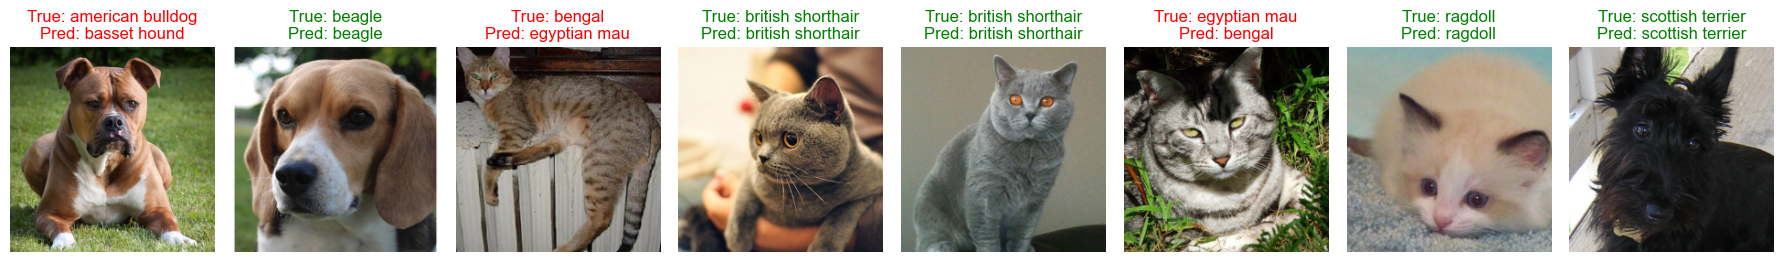

In [31]:
show_batch_results(test_dl, model_test)

### **Ablation study**

To analyze each component's contribution to the model we do an ablation study. To do this we also define two different `BaseCNN` subclasses:
- `ShallowCNN`: same network as the baseline one, with only two convolutional blocks instead of three
- `StridedCNN`: network in which the downsampling is handled by the convolutions themselves (the first `Conv2d` layer of the block has `stride=2`) instead of the `MaxPool2d` layers

In [ ]:
class ShallowCNN(BaseCNN):
    def __init__(self, deep=False):
        super().__init__(deep=deep)
        
        self.features = nn.Sequential(
            self.conv_layer(3, 32, k=7, s=2, p=3), #stem layers
            nn.MaxPool2d(2),
            ConvBlock(32, 64, s=1, bn=self.bn),
            nn.MaxPool2d(2),
            ConvBlock(64, 96, s=1, bn=self.bn),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [ ]:
class StridedCNN(BaseCNN):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            self.conv_layer(3, 32, k=7, s=2, p=3), #stem layers
            nn.MaxPool2d(2),
            ConvBlock(32, 64, s=2, bn=self.bn),
            ConvBlock(64, 96, s=2, bn=self.bn),
            ConvBlock(96, 128, s=2, bn=self.bn),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

#### **Set loop**

We define a loop to train all the models we want to compare in our ablation study. To do this we define a function to save each model's training logs in a single JSON file.

In [32]:
def save_experiment_results(results_dict, exp_name, seed):
    os.makedirs("results", exist_ok=True)
    json_path = f"results/results_seed{seed}.json"

    # Load existing file or create new
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)
    else:
        data = {}

    # Insert/overwrite this experiment’s results
    data[exp_name] = results_dict

    # Save back to disk
    # --- Atomic save ---
    tmp_path = json_path + ".tmp"
    with open(tmp_path, 'w') as f:
        json.dump(data, f, indent=4)
    os.replace(tmp_path, json_path)  # atomically replaces original file
    
    print(f"Experiment results saved in {json_path}.")

We want to do the following ablation studies:
- `no_wdecay`: weight decay parameter is set to 0
- `low_lr`: we use a lower maximum learning rate (1e-5) for the scheduler
- `strided_net`: downsampling is done with convolutions'stride
- `shallower_net`: one less `ConvBlock`
- `high_batchsize`: batch size is set to 32
- `low_batchsize`: batch size is set to 8
- `no_data_aug`: data augmentation is not used in the dataloader
- `no_batchnorm`: BatchNorm layers are removed
- `no_stem`: the first convolutional layer performs a 3x3 convolution with `stride=1` instead of a 7x7 one with `stride=2`
- `no_lrschedule`: we use a fixed learning rate with no scheduler
- `no_smoothing`: label smoothing is turned off
- `high_lr`: we use a higher maximum learning rate (1e-4) for the scheduler

In [33]:
exp_names = [
    "base",
    "no_wdecay",
    "low_lr",
    "strided_net",
    "shallower_net",
    "high_batchsize",
    "low_batchsize",
    "no_data_aug",
    "no_batchnorm",
    "no_stem",
    "no_lrschedule",
    "no_smoothing",
    "high_lr"
]
print(f"Number of ablations: {exp_names.__len__()}")

Number of ablations: 13


In [34]:
# --- Helper: apply config modifications per experiment ---
def get_cfg_for_exp(cfg, exp_name)-> dict:
    cfg_exp = copy.deepcopy(cfg)
    cfg_exp["name"] = exp_name
    cfg_exp["data_transforms"] = "train_aug"

    if exp_name == "no_data_aug":
        cfg_exp["data_transforms"] = "train_base"
    elif exp_name == "no_batchnorm":
        cfg_exp["bn"] = False
    elif exp_name == "no_stem":
        cfg_exp["stem"] = False
    elif exp_name == "no_lrschedule":
        cfg_exp["scheduler"] = False
    elif exp_name == "no_wdecay":
        cfg_exp["wd"] = 0
    elif exp_name == "low_lr":
        cfg_exp["lr"] = 1e-5
    elif exp_name == "high_lr":
        cfg_exp["lr"] = 1e-4
    elif exp_name == "high_batchsize":
        cfg_exp["batch_size"] = 32
    elif exp_name == "low_batchsize":
        cfg_exp["batch_size"] = 8
    elif exp_name == "no_smoothing":
        cfg_exp["smoothing"] = 0
    # For shallower or strided nets, we will handle models separately
    return cfg_exp

# --- Map experiment names to model constructors ---
def get_model_for_exp(cfg_exp, exp_name):
    if exp_name == "shallower_net":
        return ShallowCNN()
    elif exp_name == "strided_net":
        return StridedCNN()
    else:
        # Default: BaselineCNN with optional params from cfg
        return BaselineCNN(
            bn=cfg_exp.get("bn", True),
            stem=cfg_exp.get("stem", True)
        )

In [35]:
def count_parameters(model, only_trainable=True):
    if only_trainable:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

In [36]:
def runAndSaveOne(seed, config_dict, model, device=device) -> None:
    '''
    Function to run one configuration and save results into given json file
    1) get configuration
    2) establish model
    3) train model
    '''
    exp_name = config_dict["name"]
    json_path = f"results/results_seed{seed}.json"

    # --- Check if already trained ---
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)
        if exp_name in data and data[exp_name].get("trained", False): #get usage: if "trained" key exists get its value, otherwise output False
            #print(f"[Seed {seed}] '{exp_name}' already trained. Skipping...")
            return  # Exit early — do not retrain

    model = model.to(device)
    train_data = OxfordPetDataset(split="train", transform=data_transforms[config_dict["data_transforms"]])
    train_loader = DataLoader(train_data, batch_size=config_dict["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
    trainer = Trainer(
    model,
    train_loader,
    val_dl,
    cfg=config_dict,
    device=device
    )
    
    try:
        stats = trainer.train(print_res=False, plot_res=False)
        stats["num_params"] = count_parameters(model)
        stats["trained"] = True
    except Exception as e:
        print(f"[Seed {seed}] '{exp_name}' crashed: {e}")
        stats = {"trained": False}
    save_experiment_results(stats, exp_name, seed)


In [37]:
def runAllConfigs(seed: int) -> None:
    fix_random(seed)
    for exp_name in exp_names:
        cfg_exp = get_cfg_for_exp(cfg, exp_name)
        model_exp = get_model_for_exp(cfg_exp, exp_name)
        runAndSaveOne(seed, cfg_exp, model_exp)

    print(f"All experiments done for seed {seed}.")

In [38]:
runAllConfigs(42)

All experiments done for seed 42.


#### **Results**

First we report all the training results, then we compare some ablations together to improve readability.

In [114]:
tableau13 = [
    (0.121, 0.466, 0.705),  # blue
    (1.000, 0.498, 0.054),  # orange
    (0.172, 0.627, 0.172),  # green
    (0.839, 0.152, 0.156),  # red
    (0.580, 0.404, 0.741),  # purple
    (0.549, 0.337, 0.294),  # brown
    (0.890, 0.466, 0.760),  # pink
    (0.498, 0.498, 0.498),  # gray
    (0.737, 0.741, 0.133),  # olive
    (0.090, 0.745, 0.811),  # cyan
    (0.682, 0.780, 0.909),  # light blue
    (1.000, 0.733, 0.470),  # light orange
    (0.596, 0.875, 0.541)   # light green
]

In [115]:
# Load JSON from a file
with open("results/results_seed42.json", "r") as f:
    data = json.load(f)

In [116]:
all_data = []

for exp_name, metrics in data.items():
    n_epochs = len(metrics["train loss"])
    temp_df = pd.DataFrame({
        "epoch": range(1, n_epochs + 1),
        "train_loss": metrics["train loss"],
        "val_loss": metrics["val loss"],
        "train_acc": metrics["train acc"],
        "val_acc": metrics["val acc"],
        "train_time": metrics["train time"],
        "experiment": exp_name
    })
    all_data.append(temp_df)

df_all = pd.concat(all_data, ignore_index=True)

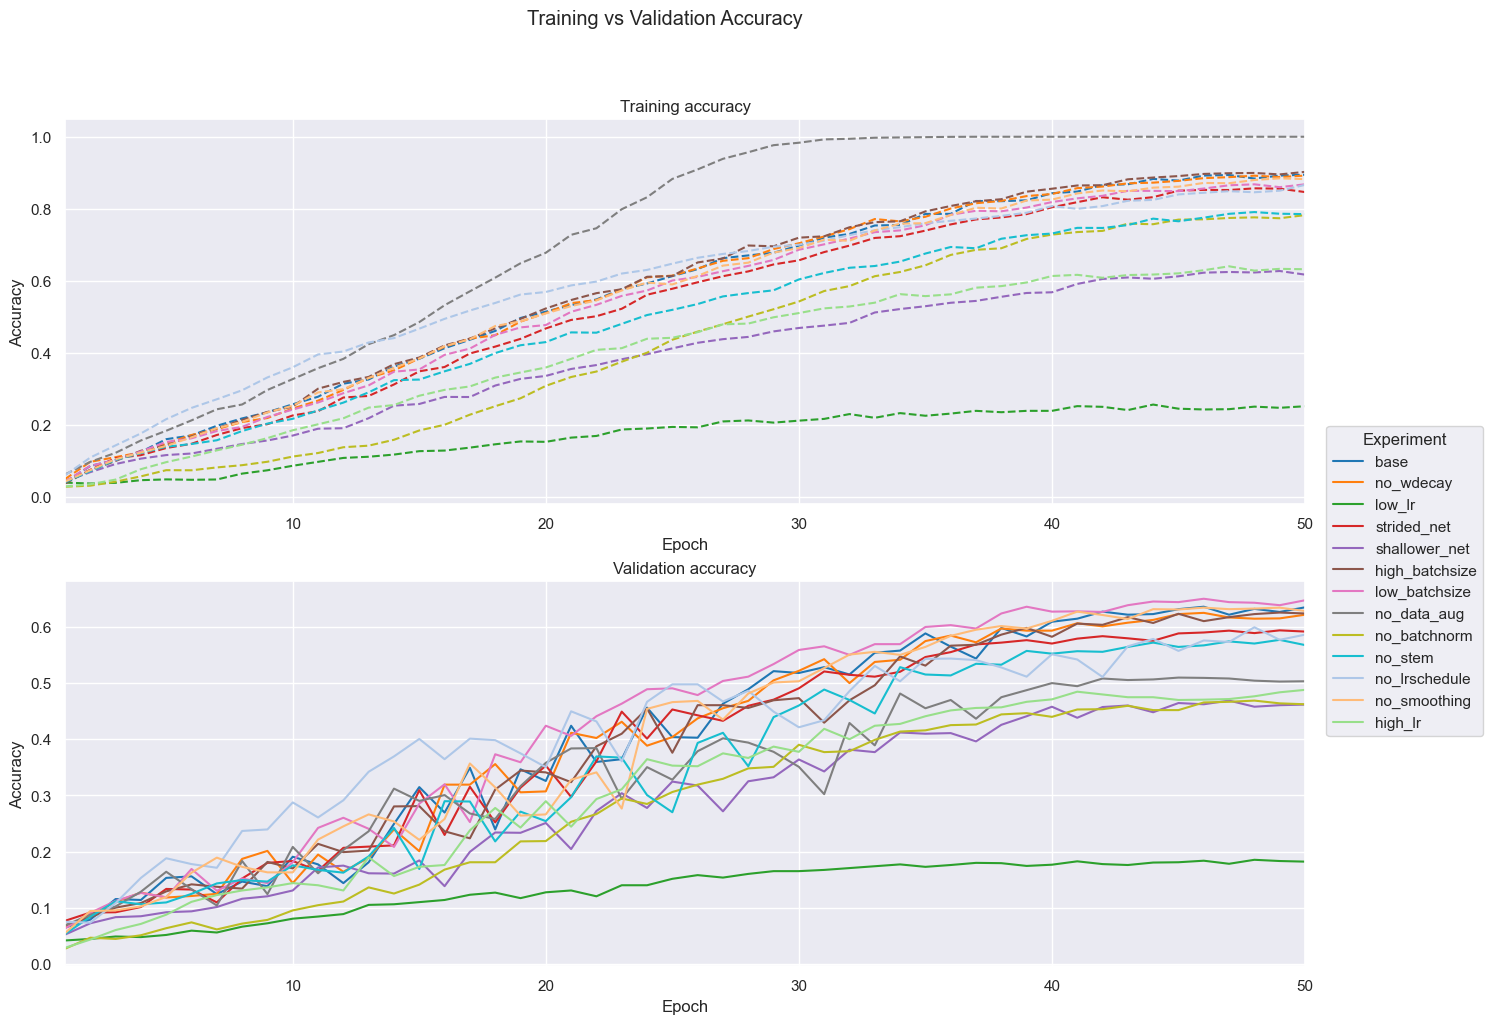

In [117]:
# Set seaborn style
sns.set_theme()
sns.set_palette(tableau13)


# --- Function to plot metrics ---
def plot_metrics(df):
    plt.figure(figsize=(16,11))
    plt.subplot(2,1,1)
    plt.title("Training accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.xlim(1, 50)
    sns.lineplot(x="epoch", y="train_acc", hue="experiment", data=df, linestyle="--", legend=False, hue_order=exp_names)
    plt.subplot(2,1,2)
    plt.title("Validation accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    sns.lineplot(x="epoch", y="val_acc", hue="experiment", data=df, legend=True, hue_order=exp_names)
    plt.xlim(1, 50)
    plt.legend(title="Experiment", loc='center right', bbox_to_anchor=(1.15, 1.00))
    plt.suptitle("Training vs Validation Accuracy")
    plt.show()

# Example usage:
plot_metrics(df_all)

We can see that for all models apart from `low_lr` validation accuracy curves seem more unstable with respect to the training ones.

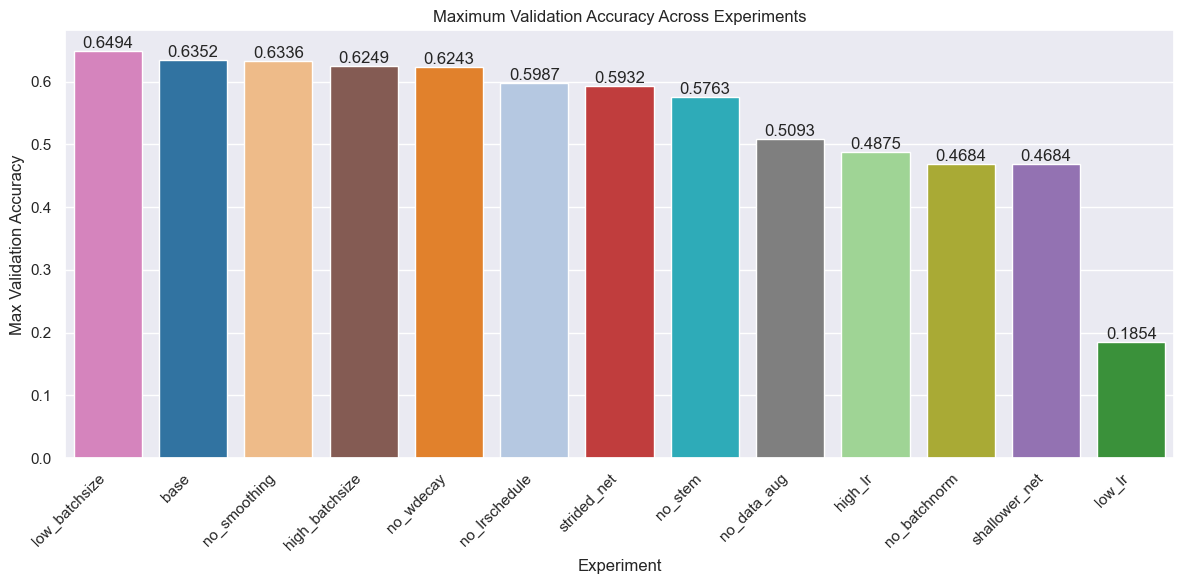

In [118]:
# Compute maximum validation accuracy per experiment
max_val_acc = df_all.groupby("experiment")["val_acc"].max().reset_index()

# Sort by max_val_acc for better visualization
max_val_acc = max_val_acc.sort_values("val_acc", ascending=False)

# Bar plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x="experiment", y="val_acc", data=max_val_acc, hue="experiment", legend=False, hue_order=exp_names)
# Annotate each bar with its value
for p in ax.patches:
    ax.text(
        x=p.get_x() + p.get_width() / 2, 
        y=p.get_height(), 
        s=f"{p.get_height():.4f}", 
        ha='center', 
        va='bottom'
    )
plt.xticks(rotation=45, ha='right')
plt.ylabel("Max Validation Accuracy")
plt.xlabel("Experiment")
plt.title("Maximum Validation Accuracy Across Experiments")
plt.tight_layout()
plt.show()


In [119]:
def get_model_memory(model, input_size=(3, 224, 224), device=device):
    f = io.StringIO()
    with redirect_stdout(f):
        summary(model.to(device), input_size, device=str(device))
    summary_str = f.getvalue()
    match = re.search(
        r"Input size \(MB\): ([\d.]+)\nForward/backward pass size \(MB\): ([\d.]+)\nParams size \(MB\): ([\d.]+)\nEstimated Total Size \(MB\): ([\d.]+)",
        summary_str,
    )
    if match:
        return dict(zip(["input_MB", "fwd_MB", "params_MB", "total_MB"], map(float, match.groups())))
    else:
        return None

### **Grouped comparisons**

We now compare groups of ablations together to have a deeper insight on the model architecture.

#### **Learning Rate**

In [120]:
summary_list = []

experiments_to_plot = ["base", "low_lr", "high_lr", "no_lrschedule"]

base_val_acc = max(data["base"]["val acc"])  # baseline for relative gain/loss
base_train_acc = max(data["base"]["train acc"])

for exp_name in experiments_to_plot:
    metrics = data[exp_name]
    max_val_acc = round(max(metrics["val acc"]), ndigits=4)
    max_train_acc = round(max(metrics["train acc"]), ndigits=4)
    
    # Relative gain/loss vs base in %
    rel_gain_val = round((max_val_acc - base_val_acc) / base_val_acc * 100, ndigits=2)
    rel_gain_train = round((max_train_acc - base_train_acc) / base_train_acc * 100, ndigits=2)
        
    summary_list.append({
        "Experiment": exp_name,
        "Max Val Accuracy": max_val_acc,
        "Diff vs Base (Val) (%)": rel_gain_val,
        "Max Train Accuracy": max_train_acc,
        "Diff vs Base (Train) (%)": rel_gain_train
    })

summary_df = pd.DataFrame(summary_list).set_index(["Experiment"])
summary_df

Max Val Accuracy  Diff vs Base (Val) (%)  Max Train Accuracy  \
Experiment                                                                    
base                     0.6352                   -0.00              0.8945   
low_lr                   0.1854                  -70.81              0.2557   
high_lr                  0.4875                  -23.26              0.6400   
no_lrschedule            0.5987                   -5.75              0.8662   

               Diff vs Base (Train) (%)  
Experiment                               
base                              -0.00  
low_lr                           -71.41  
high_lr                          -28.45  
no_lrschedule                     -3.17

- Low learning rate (`low_lr`) severely hinders learning: validation accuracy drops to 18.5% (−70.81%), and training accuracy to 25.6% (−71.41%). This shows that the optimizer fails to escape shallow minima or make sufficient progress within the same training: the model is clearly underfitting.

- High learning rate (`high_lr`) destabilizes convergence, resulting in 48.8% validation accuracy (−23.3%) and 64.0% training accuracy (−28.5%). The network likely oscillates around minima or partially diverges, never reaching full optimization, which suggests excessive step sizes harm fine-grained weight tuning.

- No learning rate scheduling (`no_lrschedule`) performs moderately well with 59.9% validation accuracy (−5.8%) and 86.6% training accuracy (−3.2%), showing that learning rate decay contributes to the final performance.

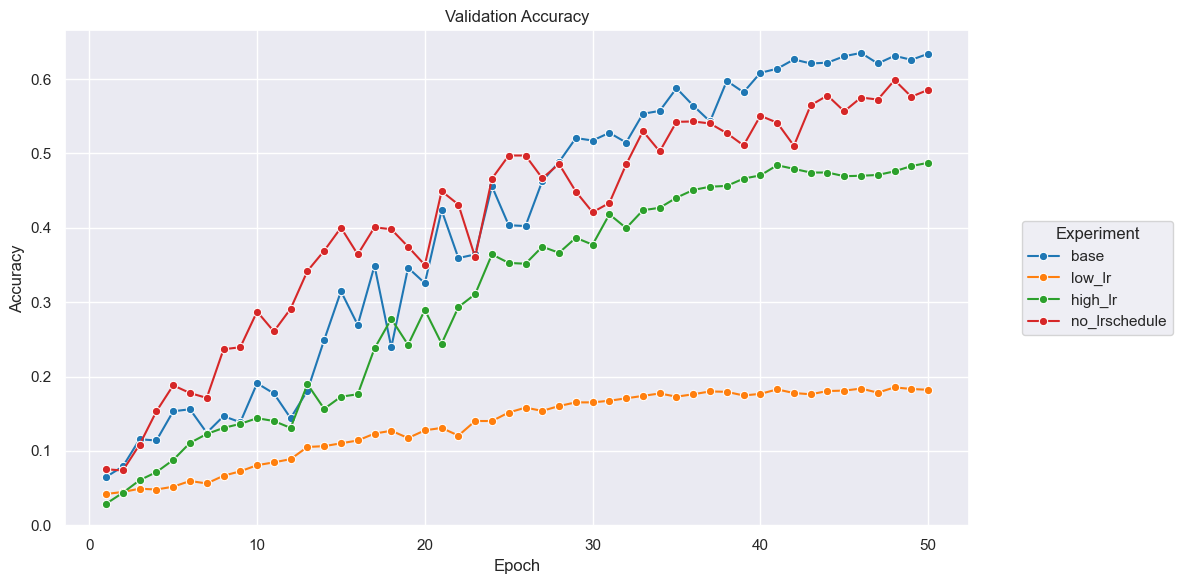

In [121]:
df_plot = df_all[df_all["experiment"].isin(experiments_to_plot)].copy()
df_plot["epoch"] = df_plot["epoch"].astype(int)
# Line plot for validation accuracy
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x="epoch",y="val_acc", hue="experiment",hue_order=experiments_to_plot, marker="o")
#sns.lineplot(data=df_plot, x="epoch",y="train_acc", hue="experiment",hue_order=experiments_to_plot, linestyle="--")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.tight_layout()
plt.show()


This plot shows clearly that while `no_lrschedule` has a higher performance in the first 20 epochs, it ultimately penalizes generalization and reaches a lower validation accuracy than the `base` model.

#### **Model Architecture**

In [122]:
# Define the experiments/models you want to include
experiments_to_plot = ["base", "strided_net", "shallower_net", "no_stem"]
experiments = {
    "base": BaselineCNN(),
    "strided_net": StridedCNN(),
    "shallower_net": ShallowCNN(),
    "no_stem": BaselineCNN(stem=False)
}

# Create a list to store table rows
table_rows = []

for exp_name in experiments_to_plot:
    # Get memory stats
    mem_stats = get_model_memory(experiments[exp_name], input_size=(3, 224, 224), device=device)
    
    # Get metrics from your df_all (max val/train accuracy, final losses)
    df_exp = df_all[df_all["experiment"] == exp_name]
    max_val_acc = round(df_exp["val_acc"].max(), ndigits=4)
    
    # Example relative gain vs base
    base_max_val_acc = df_all[df_all["experiment"] == "base"]["val_acc"].max()
    rel_gain_val = round((max_val_acc - base_max_val_acc) / base_max_val_acc * 100, ndigits=2)
    
    # Training time
    training_time = round(float(df_exp[df_exp["experiment"]==exp_name]["train_time"].iloc[-1]))
    
    # Combine all into a dict
    row = {
        "Experiment": exp_name,
        "Max Val Accuracy": max_val_acc,
        "Diff vs Base (Val) (%)": rel_gain_val,
        "Total Size (MB)": mem_stats["total_MB"],
        "Fwd/Back Pass (MB)": mem_stats["fwd_MB"],
        "Params Size (MB)": mem_stats["params_MB"],
        "Input Size (MB)": mem_stats["input_MB"],
        "Training Time (s)": training_time
    }
    
    table_rows.append(row)

# Convert to DataFrame
df_table = pd.DataFrame(table_rows).set_index("Experiment")
df_table

Max Val Accuracy  Diff vs Base (Val) (%)  Total Size (MB)  \
Experiment                                                                 
base                     0.6352                   -0.00            28.95   
strided_net              0.5932                   -6.62            16.31   
shallower_net            0.4684                  -26.26            26.57   
no_stem                  0.5763                   -9.28           108.75   

               Fwd/Back Pass (MB)  Params Size (MB)  Input Size (MB)  \
Experiment                                                             
base                        26.61              1.77             0.57   
strided_net                 13.97              1.77             0.57   
shallower_net               25.22              0.77             0.57   
no_stem                    106.42              1.75             0.57   

               Training Time (s)  
Experiment                        
base                        2807  
strided_net                 2869  
shallower_net               2791  
no_stem                     3507

- Strided network (`strided_net`) reduces the total size to 16.3 MB (≈ 44% smaller than the base) by using more stride-based downsampling instead of pooling, without changing parameter count. Its validation accuracy drops moderately to 59.3% (−6.6%), indicating a small loss in representational capacity but improved memory efficiency. Overall, it is a good lightweight variant with only a modest accuracy trade-off.

- Shallower network (`shallower_net`) cuts parameters to 0.77 MB (≈ 44% smaller than the base), keeping total memory at 26.6 MB, but validation accuracy falls sharply to 46.8% (−26.3%). This shows the model becomes under-parameterized, unable to extract sufficient hierarchical features. Training time remains similar, suggesting compute is not the bottleneck; instead, model capacity is.

- No stem layer (`no_stem`) dramatically increases total memory usage to 108.8 MB (+276%) and training time to 3507 s (+25%), while validation accuracy drops to 57.6% (−9.3%). Removing the stem causes early layers to operate on high-resolution inputs for longer, increasing activation memory and computation while providing no accuracy benefit.

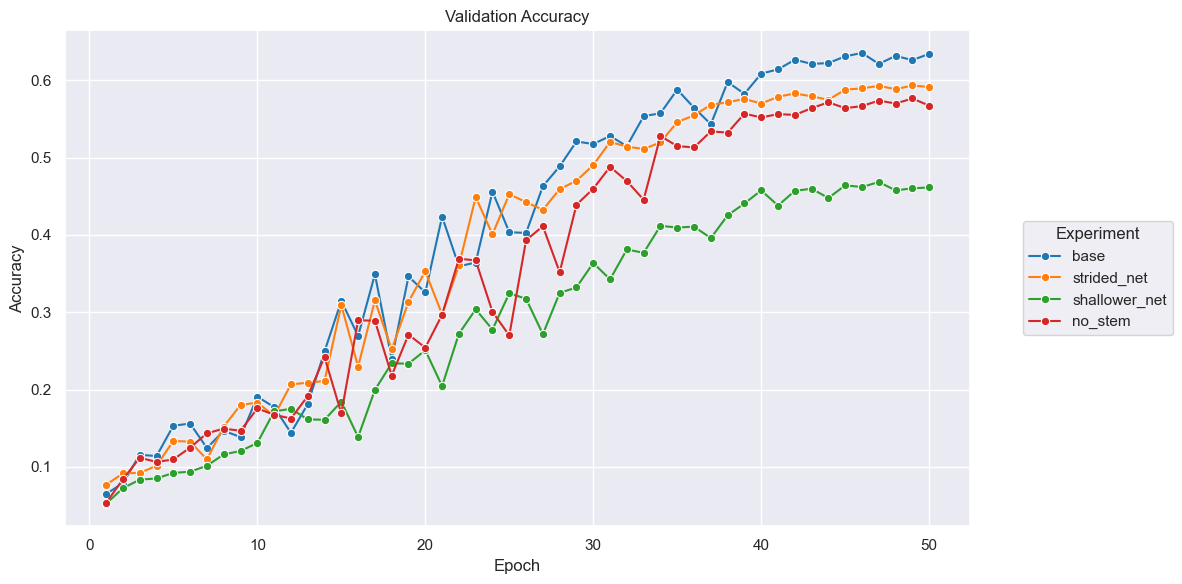

In [123]:
df_plot = df_all[df_all["experiment"].isin(experiments_to_plot)].copy()
df_plot["epoch"] = df_plot["epoch"].astype(int)
# Line plot for validation accuracy
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x="epoch",y="val_acc", hue="experiment",hue_order=experiments_to_plot, marker="o")
#sns.lineplot(data=df_plot, x="epoch",y="train_acc", hue="experiment",hue_order=experiments_to_plot, linestyle="--")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.tight_layout()
plt.show()


#### **Regularization/Generalization**

In [124]:
summary_list = []

experiments_to_plot = ["base",  "no_data_aug", "no_smoothing", "no_batchnorm", "no_wdecay"]

base_val_acc = max(data["base"]["val acc"])  # baseline for relative gain/loss
base_train_acc = max(data["base"]["train acc"])

for exp_name in experiments_to_plot:
    metrics = data[exp_name]
    max_val_acc = round(max(metrics["val acc"]), ndigits=4)
    max_train_acc = round(max(metrics["train acc"]), ndigits=4)
    
    # Relative gain/loss vs base in %
    rel_gain_val = round((max_val_acc - base_val_acc) / base_val_acc * 100, ndigits=2)
    rel_gain_train = round((max_train_acc - base_train_acc) / base_train_acc * 100, ndigits=2)

    overfitting_gap = round((max_train_acc - max_val_acc), ndigits=2)        
    summary_list.append({
        "Experiment": exp_name,
        "Max Val Accuracy": max_val_acc,
        "Diff vs Base (Val) (%)": rel_gain_val,
        "Max Train Accuracy": max_train_acc,
        "Diff vs Base (Train) (%)": rel_gain_train,
        "Train Acc - Val Acc": overfitting_gap
    })

summary_df = pd.DataFrame(summary_list).set_index(["Experiment"])
summary_df

Max Val Accuracy  Diff vs Base (Val) (%)  Max Train Accuracy  \
Experiment                                                                   
base                    0.6352                   -0.00              0.8945   
no_data_aug             0.5093                  -19.82              1.0000   
no_smoothing            0.6336                   -0.26              0.8844   
no_batchnorm            0.4684                  -26.26              0.7822   
no_wdecay               0.6243                   -1.72              0.8921   

              Diff vs Base (Train) (%)  Train Acc - Val Acc  
Experiment                                                   
base                             -0.00                 0.26  
no_data_aug                      11.79                 0.49  
no_smoothing                     -1.13                 0.25  
no_batchnorm                    -12.56                 0.31  
no_wdecay                        -0.27                 0.27

- No data augmentation (`no_data_aug`) causes the sharpest decline in validation accuracy (50.9%, −19.8%) despite reaching perfect training accuracy (100%). The gap between training and validation accuracy widens dramatically (0.49), a clear sign of severe overfitting: the model memorizes the training data without learning transferable features. This confirms that data augmentation is a crucial source of regularization in this setup.

- No label smoothing (`no_smoothing`) has a nearly identical performance to the base (−0.26% val accuracy difference), with a slightly lower training accuracy (−1.1%) and essentially the same generalization gap (0.25). This suggests that label smoothing provides only a minor regularization effect, possibly because other mechanisms (augmentation, weight decay) already stabilize training.

- No batch normalization (`no_batchnorm`) produces the largest performance degradation after removing augmentation, with validation accuracy falling to 46.8% (−26.3%) and training accuracy to 78.2% (−12.6%). The higher gap (0.31) indicates both slower convergence and weaker generalization, confirming that batch normalization is critical for stable optimization and feature scaling in this model.

- No weight decay (`no_wdecay`) slightly reduces validation accuracy (62.4%, −1.7%) and training accuracy (89.2%, −0.3%) while keeping a similar generalization gap (0.27). The impact is small but consistent with a mild overfitting tendency—showing that while weight decay isn’t the dominant factor, it still contributes to regularization.

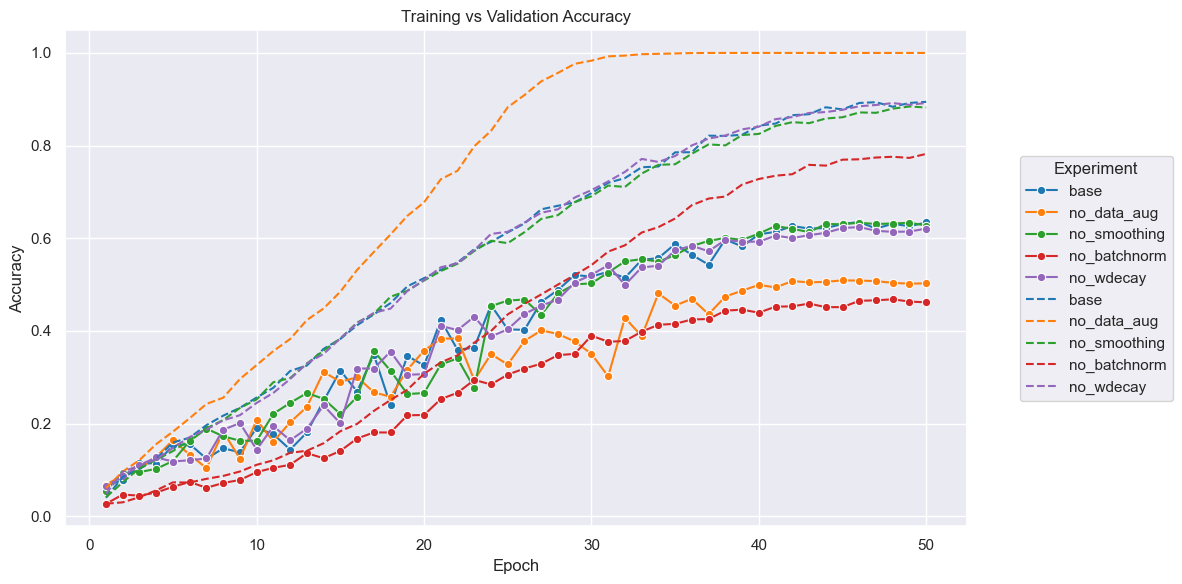

In [125]:
df_plot = df_all[df_all["experiment"].isin(experiments_to_plot)].copy()
df_plot["epoch"] = df_plot["epoch"].astype(int)
# Line plot for validation accuracy
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x="epoch",y="val_acc", hue="experiment",hue_order=experiments_to_plot, marker="o")
sns.lineplot(data=df_plot, x="epoch",y="train_acc", hue="experiment",hue_order=experiments_to_plot, linestyle="--")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.tight_layout()
plt.show()


From the plots we can see that even if validation accuracy-wise the `no_data_aug` and the `no_batchnorm` models reach similar values, training-wise they have different behaviors:
- `no_data_aug` reaches model saturation after 35 epochs, suggesting more overfitting
- `no_batchnorm` has lower training accuracy w.r.t. all the other models, suggesting a worse generalization ability

#### **Batch Size**

In [126]:
summary_list = []

experiments_to_plot = ["base",  "high_batchsize", "low_batchsize"]

base_val_acc = max(data["base"]["val acc"])  # baseline for relative gain/loss
base_train_acc = max(data["base"]["train acc"])

for exp_name in experiments_to_plot:
    metrics = data[exp_name]
    max_val_acc = round(max(metrics["val acc"]), ndigits=4)
    max_train_acc = round(max(metrics["train acc"]), ndigits=4)
    
    # Relative gain/loss vs base in %
    rel_gain_val = round((max_val_acc - base_val_acc) / base_val_acc * 100, ndigits=2)
    rel_gain_train = round((max_train_acc - base_train_acc) / base_train_acc * 100, ndigits=2)
        
    summary_list.append({
        "Experiment": exp_name,
        "Max Val Accuracy": max_val_acc,
        "Diff vs Base (Val) (%)": rel_gain_val,
        "Max Train Accuracy": max_train_acc,
        "Diff vs Base (Train) (%)": rel_gain_train,
    })

summary_df = pd.DataFrame(summary_list).set_index(["Experiment"])
summary_df

Max Val Accuracy  Diff vs Base (Val) (%)  Max Train Accuracy  \
Experiment                                                                     
base                      0.6352                   -0.00              0.8945   
high_batchsize            0.6249                   -1.63              0.9024   
low_batchsize             0.6494                    2.23              0.8678   

                Diff vs Base (Train) (%)  
Experiment                                
base                               -0.00  
high_batchsize                      0.88  
low_batchsize                      -2.99

- High batch size (`high_batchsize`) slightly reduces validation accuracy (62.5%, −1.6%) while slightly increasing training accuracy (90.2%, +0.9%). This is likely because larger batches provide smoother gradient estimates, which can reduce the implicit regularization effect that smaller batches often provide.

- Low batch size (`low_batchsize`) improves validation accuracy slightly (64.9%, +2.2%) while reducing training accuracy (86.8%, −3.0%). This indicates better generalization, as smaller batches inject more stochastic noise into gradient updates, which acts as implicit regularization, preventing overfitting to the training set.

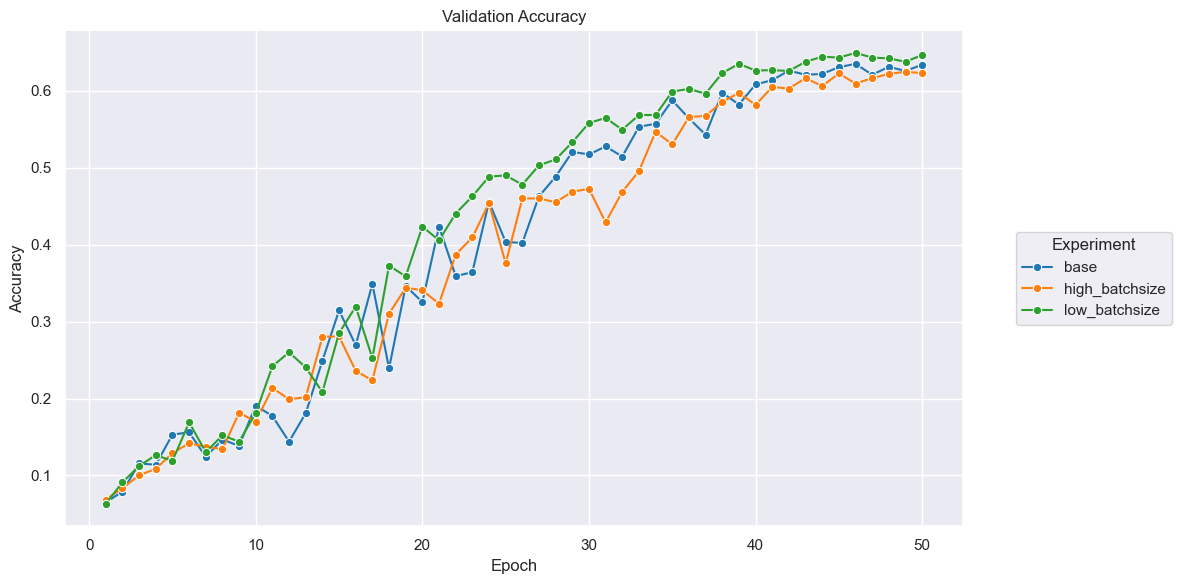

In [127]:
df_plot = df_all[df_all["experiment"].isin(experiments_to_plot)].copy()
df_plot["epoch"] = df_plot["epoch"].astype(int)
# Line plot for validation accuracy
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x="epoch",y="val_acc", hue="experiment",hue_order=experiments_to_plot, marker="o")
#sns.lineplot(data=df_plot, x="epoch",y="train_acc", hue="experiment",hue_order=experiments_to_plot, linestyle="--")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.tight_layout()
plt.show()


## **PART 2: ResNet fine-tuning**

### **2.A: fine-tune with same hyperparameters**

We now fine-tune a `ResNet18` model with the same hyperparameters used in Part 1. To do this, we have to override the old classifier with a Fully Connected layer that outputs 37 classes (instead of the original 1000 classes of the ImageNet dataset).

In [128]:
def get_model(
        num_classes: int,
        weights: Optional[ResNet18_Weights] = None
    ) -> nn.Module:
    """Gets an image classifier based on ResNet-18.

    Args:
        num_classes: the number of classes.
        weights: pretrained weights to load into the network.
                 If None, the network is randomly initialized.

    Returns:
        The required network.
    """
    model = resnet18(weights=weights)
    # Here we override the old classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

At first we completely freeze the feature extractor part and we only train our classifier using out previous hyperparameters.

In [129]:
weights = ResNet18_Weights.IMAGENET1K_V1
net_transfer = get_model(num_classes=37, weights=weights).to(device)

set_requires_grad(net_transfer.conv1, False)
set_requires_grad(net_transfer.bn1, False)
set_requires_grad(net_transfer.layer1, False)
set_requires_grad(net_transfer.layer2, False)
set_requires_grad(net_transfer.layer3, False)
set_requires_grad(net_transfer.layer4, False)

summary(
    net_transfer,
    input_size=(3, cfg["crop_size"], cfg["crop_size"])
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [130]:
cfg_rn = copy.deepcopy(cfg)
cfg_rn["name"] = "resnet"
cfg_rn["num_epochs"] = 10
cfg_rn

{'resize_size': 256,
 'crop_size': 224,
 'batch_size': 16,
 'num_epochs': 10,
 'lr': 0.0005,
 'wd': 0.0002,
 'patience': 10,
 'smoothing': 0.1,
 'scheduler': True,
 'name': 'resnet'}

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss = 3.6067
[train] loss = 3.6067, acc = 0.0529
[val] loss = 3.1855, acc = 0.1576
✅ Saved new resnet best model with acc = 0.1576
Epoch 2: Train loss = 2.6394
[train] loss = 2.6394, acc = 0.4535
[val] loss = 1.6848, acc = 0.6908
✅ Saved new resnet best model with acc = 0.6908
Epoch 3: Train loss = 1.6893
[train] loss = 1.6893, acc = 0.7599
[val] loss = 0.9896, acc = 0.8152
✅ Saved new resnet best model with acc = 0.8152
Epoch 4: Train loss = 1.3636
[train] loss = 1.3636, acc = 0.8327
[val] loss = 0.7977, acc = 0.8266
✅ Saved new resnet best model with acc = 0.8266
Epoch 5: Train loss = 1.2508
[train] loss = 1.2508, acc = 0.8602
[val] loss = 0.7106, acc = 0.8326
✅ Saved new resnet best model with acc = 0.8326
Epoch 6: Train loss = 1.1976
[train] loss = 1.1976, acc = 0.8711
[val] loss = 0.6630, acc = 0.8413
✅ Saved new resnet best model with acc = 0.8413
Epoch 7: Train loss = 1.1661
[train] loss = 1.1661, acc = 0.8847
[val] loss = 0.6094, acc = 0.8550
✅ Saved new resnet 

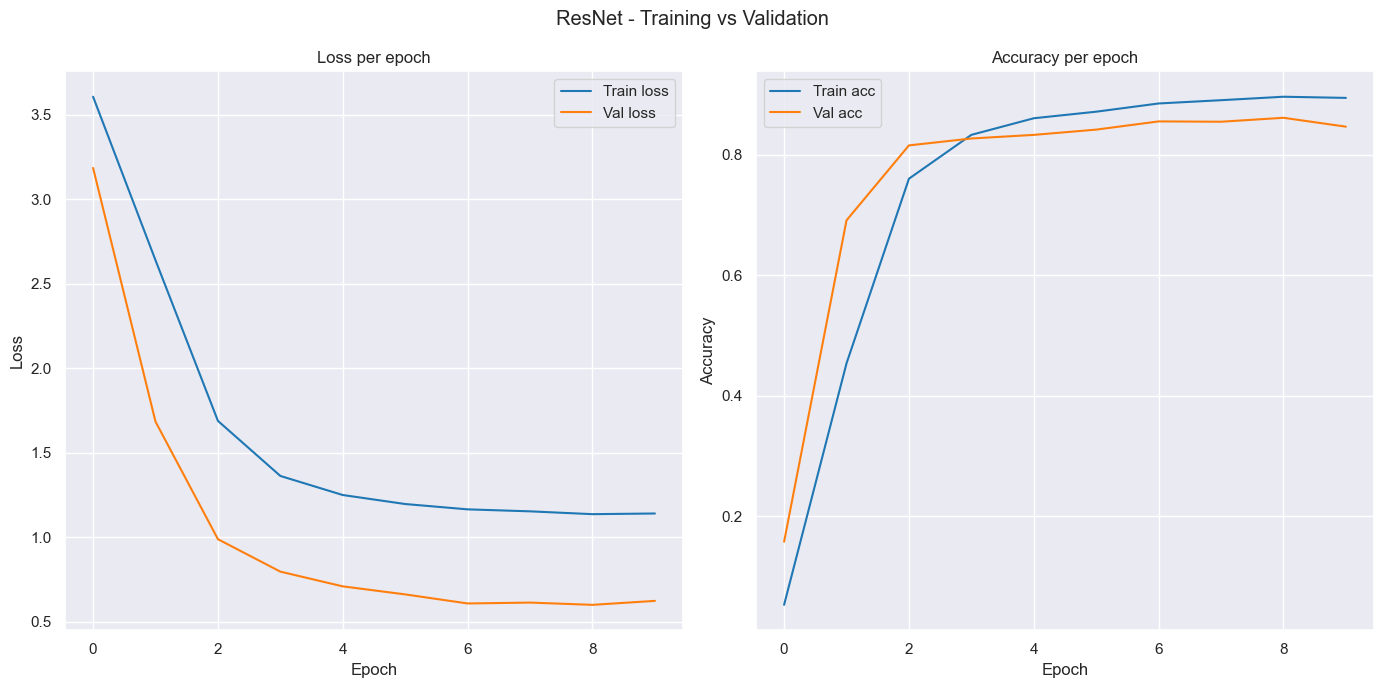

In [131]:
trainer_res1 = Trainer(
    net_transfer,
    train_dl,
    val_dl,
    cfg=cfg_rn
)
stats_res1 = trainer_res1.train()

In [132]:
rn_model_test = load_model(get_model(num_classes=37, weights=weights), cfg=cfg_rn, device=device)

In [133]:
tester_res1 = Tester(rn_model_test, test_dl, device, num_classes=37)
test_metrics_res1 = tester_res1.evaluate(plot_cm=False)

[test] loss = 0.5417, acc = 0.8716


### **2.B: find optimal hyperparameters**

Now we unfreeze `layer4`, we lower the maximum learning rate to 1e-5 and we disable weight decay.

In [134]:
cfg_rn_ft = copy.deepcopy(cfg_rn)
cfg_rn_ft["name"] = "resnet_ft"
cfg_rn_ft["num_epochs"] = 8
cfg_rn_ft["patience"] = 5
cfg_rn_ft["lr"] /= 10
cfg_rn_ft["wd"] = 0
cfg_rn_ft

{'resize_size': 256,
 'crop_size': 224,
 'batch_size': 16,
 'num_epochs': 8,
 'lr': 5e-05,
 'wd': 0,
 'patience': 5,
 'smoothing': 0.1,
 'scheduler': True,
 'name': 'resnet_ft'}

In [135]:
set_requires_grad(net_transfer.layer4, True)

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1: Train loss = 1.1254
[train] loss = 1.1254, acc = 0.9041
[val] loss = 0.5977, acc = 0.8555
✅ Saved new resnet_ft best model with acc = 0.8555
Epoch 2: Train loss = 1.0836
[train] loss = 1.0836, acc = 0.9101
[val] loss = 0.5301, acc = 0.8686
✅ Saved new resnet_ft best model with acc = 0.8686
Epoch 3: Train loss = 1.0250
[train] loss = 1.0250, acc = 0.9297
[val] loss = 0.5211, acc = 0.8691
✅ Saved new resnet_ft best model with acc = 0.8691
Epoch 4: Train loss = 0.9686
[train] loss = 0.9686, acc = 0.9430
[val] loss = 0.5083, acc = 0.8800
✅ Saved new resnet_ft best model with acc = 0.8800
Epoch 5: Train loss = 0.9168
[train] loss = 0.9168, acc = 0.9681
[val] loss = 0.5129, acc = 0.8751
Epoch 6: Train loss = 0.8966
[train] loss = 0.8966, acc = 0.9695
[val] loss = 0.5222, acc = 0.8806
✅ Saved new resnet_ft best model with acc = 0.8806
Epoch 7: Train loss = 0.8705
[train] loss = 0.8705, acc = 0.9809
[val] loss = 0.5196, acc = 0.8757
Epoch 8: Train loss = 0.8657
[train] loss = 0.8657, 

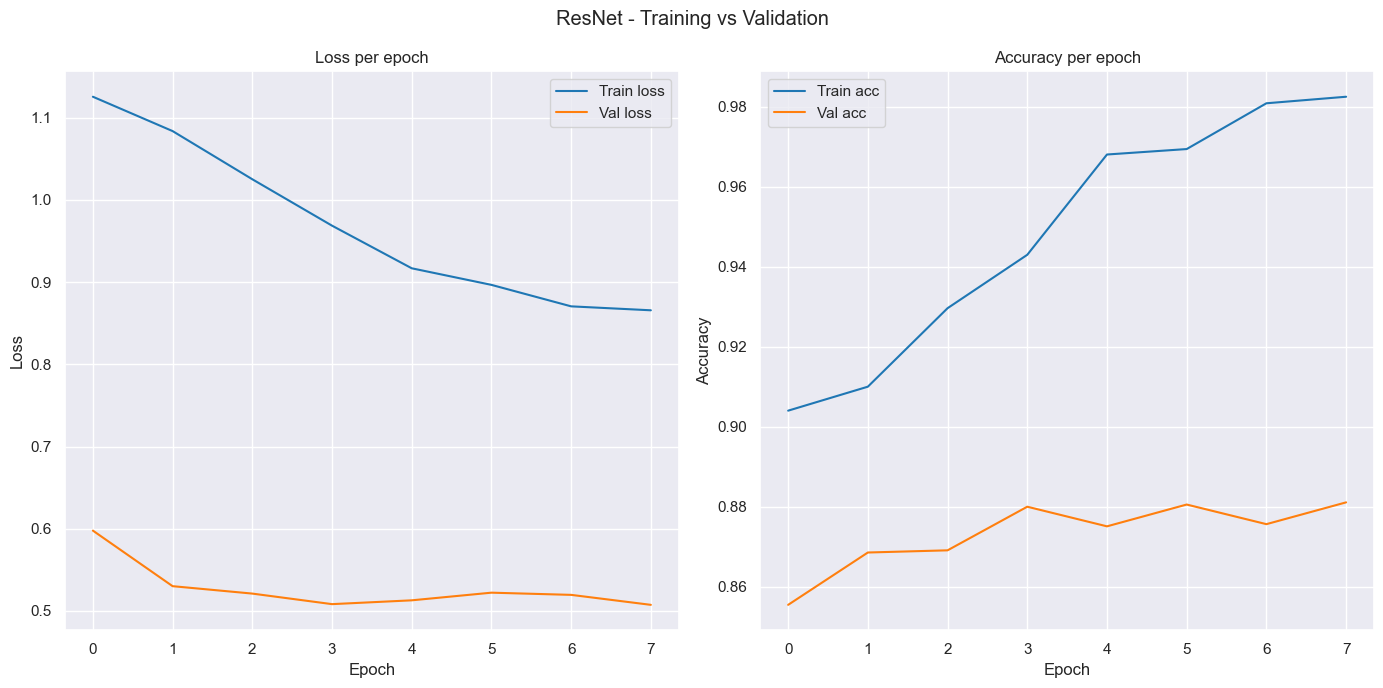

In [136]:
torch.cuda.empty_cache()
trainer_res2 = Trainer(
    net_transfer,
    train_dl,
    val_dl,
    cfg=cfg_rn_ft
)
stats2 = trainer_res2.train()

In [137]:
ft_model_test = load_model(get_model(num_classes=37, weights=weights), cfg=cfg_rn_ft, device=device)
tester_res2 = Tester(ft_model_test, test_dl, device, num_classes=37)
test_metrics_res2 = tester_res2.evaluate(plot_cm=False)

[test] loss = 0.4376, acc = 0.8917


Our model now reaches **89,17%** accuracy on the **test set**. We then show how our model behaves on some test images.

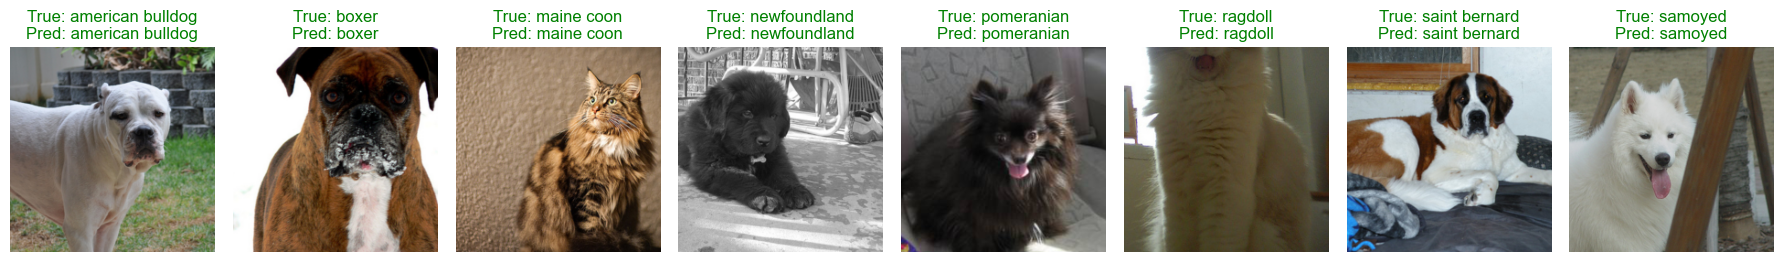

In [140]:
show_batch_results(test_dl, ft_model_test)

## **Sources**

- Code from Lab Sessions 4 and 5 of the IPCV course